## Detector de **SPAM**

### Objetivo do projeto

Este projeto tem o objetivo de mostrar como o **Multilayer Perceptron** pode ser utilizado para a detecção de SPAM. Embora o projeto esteja em Língua Portuguesa do Brasil, a base de SMS utilizada foi [encontrada no Kaggle](https://www.kaggle.com/code/dhgupta/bag-of-words-model/input), em Língua Inglesa, com o original disponibilizado em `data/spam.csv`.

Muitos projetos para a avaliação de SPAM em Língua Inglesa existem, assim deseja-se que este projeto faça tal classificação em Língua Portuguesa sendo necessário, para tanto, a tradução de toda a base de dados que será feita da seguinte forma:

1. Utilização de *small language models* no [Ollama](https://ollama.com) para rodar *small language models* local;
1. Utilização do modelo [Quen2.5 Translator](https://ollama.com/lauchacarro/qwen2.5-translator) para a tradução do texto para a língua portuguesa, com revisão humana superficial (arquivo gerado em `data/spam_br.csv`).

### Correção gramatical da base de dados em inglês

Nesta parte vamos gerar o arquivo `data/spam_en.csv` que será o resultado da correção gramatical aplicada no arquivo original `data/spam.csv`.

In [1]:
# Instalar pacotes necessários
%pip install -q pandas matplotlib seaborn wordcloud nltk tqdm ollama

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Processa verificação gramática das mensagens usando Ollama
import os
from scripts.translate import translation

input_csv = 'data/spam.csv'
output_csv = 'data/spam_br.csv'

if not os.path.exists(output_csv):
    translation(input_csv, output_csv) 
else:
    print(f'O arquivo {output_csv} já existe.')

O arquivo data/spam_br.csv já existe.


### Análise dos dados

O primeiro passo em um projeto dessa natureza é analisar os dados. Para tanto, faremos uma leitura da base original e vamos contar o número palavras e frases. Ao final dessa tarefa, vamos decidir por executar ou não algum pré-processamento.

In [6]:
# Importar bibliotecas necessárias
import pandas as pd                    # Leitura e manipulação de dados em DataFrames
import matplotlib.pyplot as plt        # Gráficos e visualizações
import seaborn as sns                  # Gráficos estatísticos com uma estética aprimorada
from wordcloud import WordCloud        # Nuvens de palavras
import nltk                            # Processamento de linguagem natural (NLP)
from nltk.corpus import stopwords      # Lstas de stopwords (palavras irrelevantes)
from collections import Counter        # Frequência de elementos

#### Leitura do `data/spam_br.csv`

In [10]:
# Leitura dos dados
spam = pd.read_csv('data/spam_br.csv', encoding='utf-8')
spam = spam[['Label', 'EmailTextBR']]
spam.columns = ['label', 'sms']
print(f'Linhas da base SPAM original: {spam.shape}')
spam.head()

Linhas da base SPAM original: (5572, 2)


,label,sms
0,ham,"Vá até o ponto de Jurong, louco. Disponível so..."
1,ham,Ok lábio... Jogando com você...
2,spam,Entrada gratuita em 2 compilações semanais par...
3,ham,"U deu dizer assim cedo... U já está, então diz..."
4,ham,"Não acho que ele vai para usf, mas vive aqui p..."


#### Contagem de SPAM e HAM

In [11]:
# Estatísticas básicas
spam['word_count'] = spam['sms'].apply(lambda x: len(x.split()))
spam['char_count'] = spam['sms'].apply(len)

# Contar mensagens por categoria (ham/spam)
sms_by_label = spam['label'].value_counts().to_frame(name='Número de SMS')
sms_by_label.index.name = 'label'

# Média de palavras por mensagem
words_by_sms = spam.groupby('label')['word_count'].mean().to_frame(name='Média palavras por SMS')

# Juntar os dois DataFrames
sms_by_label.join(words_by_sms)

,Número de SMS,Média palavras por SMS
label,,
ham,4825,14.327254
spam,747,27.551539


#### Maiores e menores SMSs

In [12]:
# Maiores e menores SMSs
maiores = spam.sort_values(by='char_count', ascending=False).head(5)
menores = spam.sort_values(by='char_count', ascending=True).head(5)
maiores_menores = pd.concat([maiores, menores], axis=0)
maiores_menores[['label', 'char_count', 'word_count', 'sms']].reset_index(drop=True)

,label,char_count,word_count,sms
0,ham,1012,185,For eu o amor deve começar com atracção. Eu de...
1,ham,838,156,O último que eu queria fazer era te machucar. ...
2,ham,723,121,Triste história de um homem - A semana passada...
3,ham,723,121,Triste história de um homem - A semana passada...
4,ham,667,117,"Indígenas são pobres, mas a Índia não é uma po..."
5,ham,2,1,:)
6,ham,2,1,Ok
7,spam,2,1,OK
8,ham,2,1,Ok
9,ham,2,1,Ok


#### Histograma do tamanho das mensagens

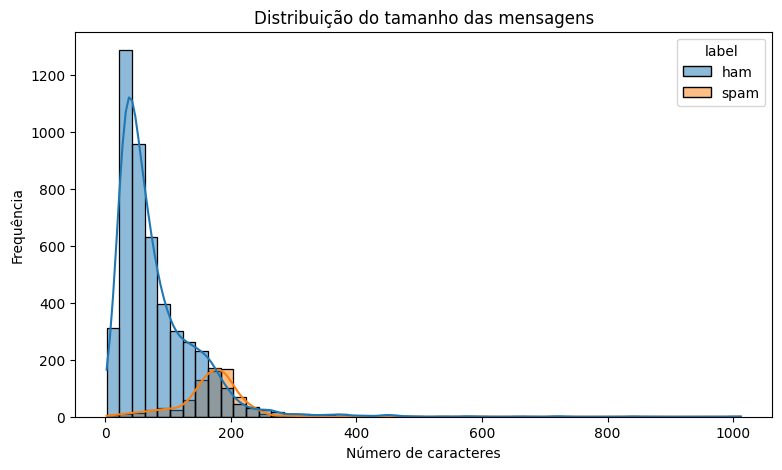

In [21]:
# Histograma do comprimento das mensagens
plt.figure(figsize=(9,5))
sns.histplot(data=spam, x='char_count', hue='label', bins=50, kde=True)
plt.title('Distribuição do tamanho das mensagens')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.show()

#### Nuvem de palavras

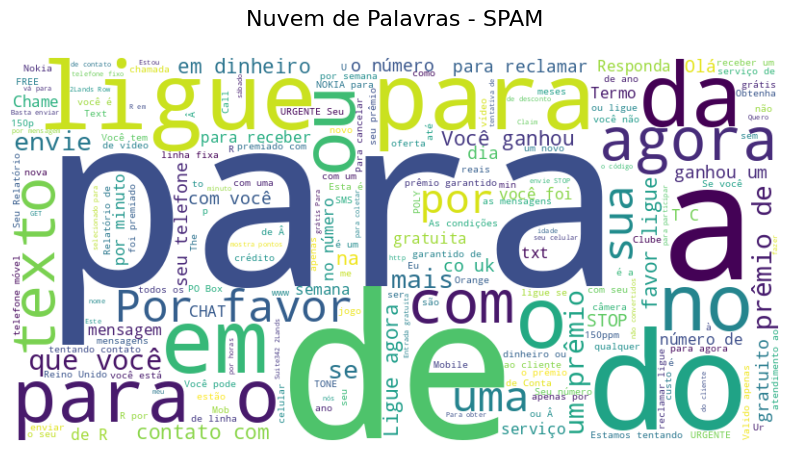

<Figure size 640x480 with 0 Axes>

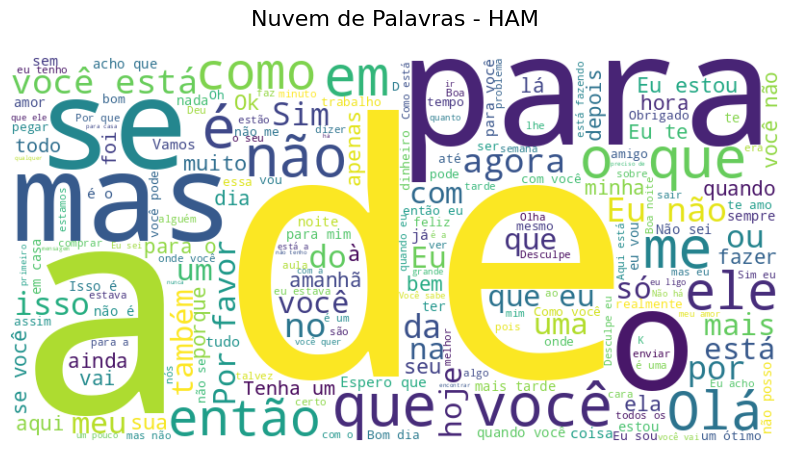

<Figure size 640x480 with 0 Axes>

In [39]:
# Nuvem de palavras
def generate_wordcloud(text, title, save_path=None):
    wc = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)
    
    # Cria a figura
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    
    # Exibe
    plt.show()

    # Salva
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight', dpi=300)

spam_text = ' '.join(spam[spam['label'] == 'spam']['sms'])
ham_text = ' '.join(spam[spam['label'] == 'ham']['sms'])

generate_wordcloud(spam_text, 'Nuvem de Palavras - SPAM\n', save_path='figures/nuvem_palavras_spam.png')
generate_wordcloud(ham_text, 'Nuvem de Palavras - HAM\n', save_path='figures/nuvem_palavras_ham.png')

#### Análise de Frequência de Palavras

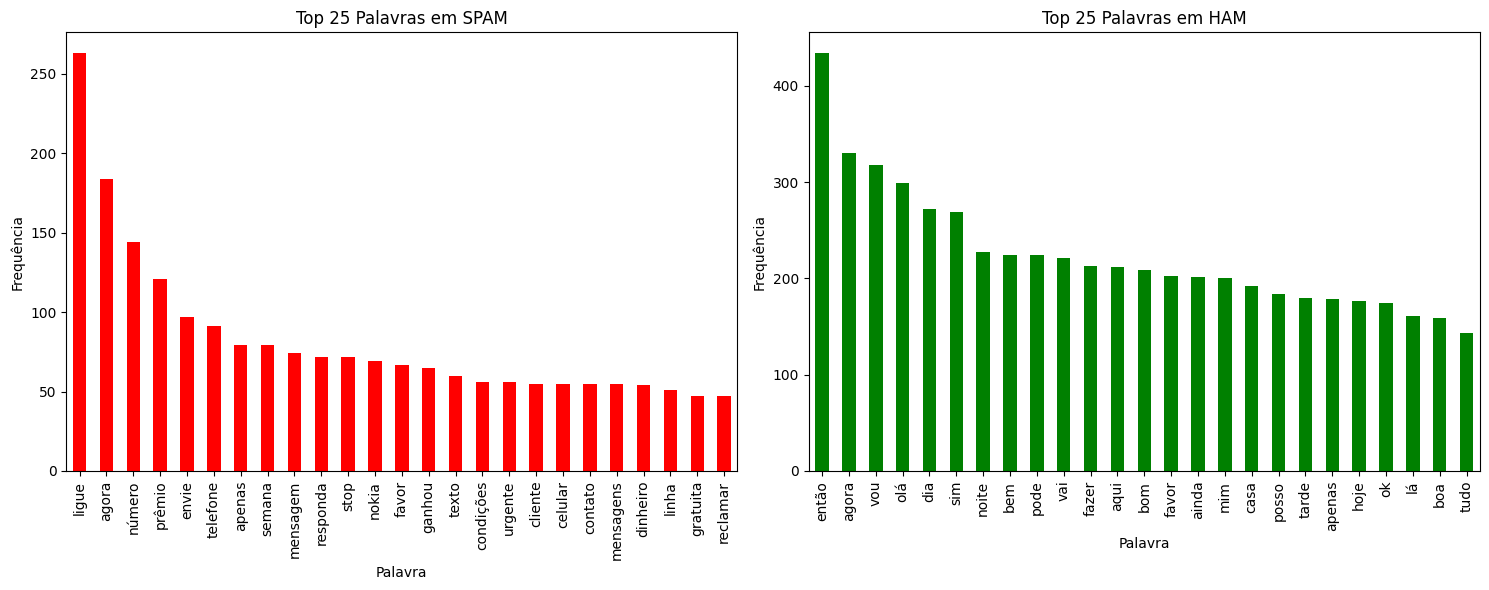

<Figure size 640x480 with 0 Axes>

In [40]:
# Frequência de palavras
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Função de limpeza e tokenização
def get_word_frequencies(text_series):
    stop_words = set(stopwords.words('portuguese'))
    all_words = []
    for message in text_series:
        # Tokenizar
        words = nltk.word_tokenize(message.lower())
        # Remover pontuações, stopwords e palavras com uma única letra
        words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 1]
        all_words.extend(words)
    return Counter(all_words)

# Frequências de palavras
spam_freq = get_word_frequencies(spam[spam['label'] == 'spam']['sms'])
ham_freq = get_word_frequencies(spam[spam['label'] == 'ham']['sms'])

# Transformar as frequências em DataFrame para visualização
common_words = 25
spam_df = pd.DataFrame(spam_freq.most_common(common_words), columns=["Palavra", "Frequência"])
ham_df = pd.DataFrame(ham_freq.most_common(common_words), columns=["Palavra", "Frequência"])

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras para SPAM
spam_df.plot(kind='bar', x='Palavra', y='Frequência', ax=ax1, color='red', legend=False)
ax1.set_title(f'Top {common_words} Palavras em SPAM')
ax1.set_xlabel('Palavra')
ax1.set_ylabel('Frequência')

# Gráfico de barras para HAM
ham_df.plot(kind='bar', x='Palavra', y='Frequência', ax=ax2, color='green', legend=False)
ax2.set_title(f'Top {common_words} Palavras em HAM')
ax2.set_xlabel('Palavra')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.show()
plt.savefig('figures/top_25_palavras.png', format='png', bbox_inches='tight', dpi=300)

### Resultado da análise

* O total de mensagens na base de dados é apresentado a seguir, separadas pelo grupo Label.

    | **Label** | **Número de SMS** | **Média de palavras por SMS** |
    |-----------|-------------------|------------------------------|
    | ham       | 4825              | 14.33                        |
    | spam      | 747               | 27.55                        |
    | **Total** | **5572**          | **16.38**                    |


* De acordo com a análise até o momento, temos um claro desbalanceamento nas classes.

    | Classe | Nº de amostras | Palavras por mensagem (média) |
    | ------ | -------------- | ----------------------------- |
    | ham    | 4.825          | \~14                          |
    | spam   | 747            | \~27                          |

    A classe `ham` representa cerca de 87% dos dados. Um modelo treinado sem cuidado pode aprender a simplesmente prever tudo como `ham` e ainda parecer `preciso`.
    
    **Foi o que aconteceu no projeto do diabetes**, onde as classes estavam demasiadamente desbalanceadas. O Pedro, como bom estatístico, faz os dados falarem o que ele quer de forma convincente, só eu não fiquei convencido daqueles resultados: **Os modelos apresentados, tanto a versão MLP quanto a logística, NÃO FUNCIONAVAM!**
    
    Tentei insistir para corrigir, mas fui voto vencido.

* Como este projeto estou fazendo sozinho, não vou permitir desbalanceamentos. Para corrigir vou usar uma ou mais das possibilidades:

    1. Na hora de chamar o treinador MLP, dar peso maior para a classe 'desbalanceada':
        ```
        mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42, class_weight='balanced')
        ```

    1. Usar o `SMOTE` para fazer criar amostras sintéticas da classe `spam`
        ```
        from imblearn.over_sampling import SMOTE

        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        ```

    1. Remover dados da classe `ham`, mas não vou seguir essa abordagem dado que a quantidade de dados já está baixa.

    1. Uma outra atividade que podemos fazer é a produção de novos dados com base na correção gramatical do inglês e na tradução para o português, o que seria desejável.

* A frequência das 25 palavras mais frequentes, para cada categoria, é apresentado à seguir.

    <div style="display: flex;">
    <img src="./figures/nuvem_palavras_ham.png" alt="Ham" style="margin-right: 20px; width: 45%;">
    <img src="./figures/nuvem_palavras_spam.png" alt="Spam" style="width: 45%;">
    </div>
    